### 필요한 라이브러리 import

In [1]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### 실험환경 Set-up

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

### 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# validation data의 수가 너무 적으므로, train data 중 일부를 validation data로 사용해 비율이 8:2가 되게 한다.

filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# train data 내, 정상 이미지와 폐렴 이미지의 수를 확인

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1066
Pneumonia images count in training set: 3119


**폐렴 이미지의 수가 정상 이미지의 수보다 3배 정도 많으므로, 데이터의 imbalance를 해결해줘야 한다.**

In [6]:
# tf.data 인스턴스 생성

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# train dataset과 validation dataset의 이미지 수를 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
# 라벨명 확인

CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [9]:
# 라벨 데이터를 위한 함수 생성

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

In [10]:
# 이미지 크기 통일 및 축소

def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# train dataset과 validation dataset 생성

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 크기 조정과 라벨 설정이 올바르게 됐는지 확인

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
# test dataset 생성

test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# tf.data의 파이프라인을 통해 학습 데이터를 효율적으로 활용하기 위한 함수 정의

def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

normal_train_ds = prepare_for_training(train_ds)
normal_val_ds = prepare_for_training(val_ds)

In [15]:
# data augementation을 적용한 방식의 함수 정의

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_augmented_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

aug_train_ds = prepare_for_augmented_training(train_ds)
aug_val_ds = prepare_for_augmented_training(val_ds)

### 데이터 시각화

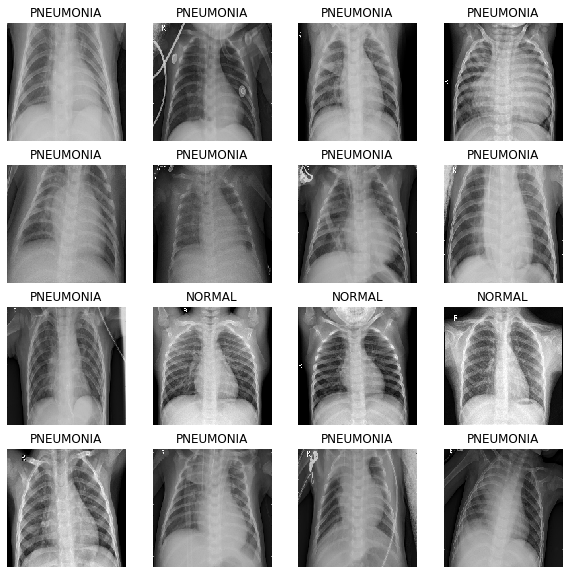

In [59]:
image_batch, label_batch = next(iter(normal_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

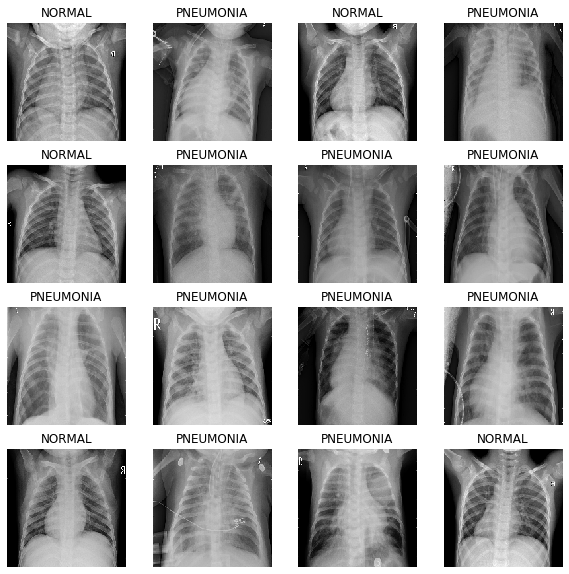

In [60]:
image_batch, label_batch = next(iter(aug_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델링

In [16]:
# convolution block을 생성하는 함수 정의

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()])
    
    return block

In [25]:
def conv_block_dropout(filters, drop_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(drop_rate),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()])
    
    return block

In [17]:
# dense block을 생성하는 함수 정의

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def dense_block_bn(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block

def dense_block_do(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
# model building을 위한 함수 정의

def build_model_0():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

def build_model_1():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_bn(512),
        dense_block_bn(128),
        dense_block_bn(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_do(512, 0.7),
        dense_block_do(128, 0.5),
        dense_block_do(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


### 모델 훈련

In [69]:
with tf.device('/GPU:0'):
    model = build_model_0()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [71]:
with tf.device('/GPU:0'):
    history = model.fit(
        normal_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=normal_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 45s 172ms/step - loss: 0.4013 - accuracy: 0.8034 - precision: 0.9528 - recall: 0.7740 - val_loss: 0.7312 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 37s 141ms/step - loss: 0.2489 - accuracy: 0.9054 - precision: 0.9721 - recall: 0.8984 - val_loss: 1.0180 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 36s 138ms/step - loss: 0.2216 - accuracy: 0.9193 - precision: 0.9702 - recall: 0.9199 - val_loss: 0.1791 - val_accuracy: 0.9279 - val_precision: 0.9943 - val_recall: 0.9073
Epoch 4/25
261/261 [==============================] - 36s 136ms/step - loss: 0.1842 - accuracy: 0.9318 - precision: 0.9773 - recall: 0.9297 - val_loss: 0.2254 - val_accuracy: 0.8865 - val_precision: 0.8670 - val_recall: 0.9987
Epoch 5/25
261/261 [==============================] - 37s 142ms/step - loss: 0.1707 - accura

### 결과 확인과 시각화

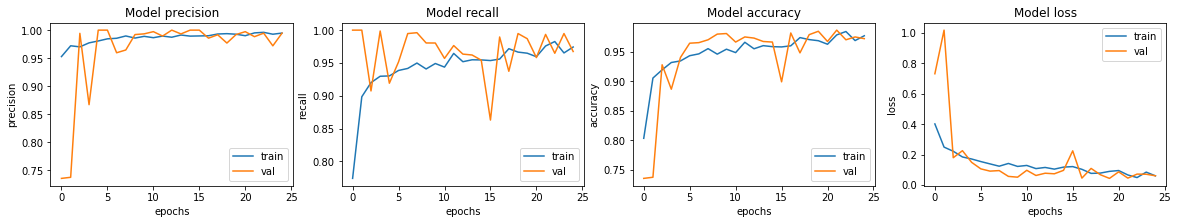

In [72]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [73]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 4s 97ms/step - loss: 1.1099 - accuracy: 0.8141 - precision: 0.7773 - recall: 0.9846


**dense_block에서 dropout layer 제거한 model**

In [20]:
with tf.device('/GPU:0'):
    model = build_model_1()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        normal_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=normal_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 38s 147ms/step - loss: 0.2737 - accuracy: 0.8853 - precision: 0.9713 - recall: 0.8717 - val_loss: 0.6377 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 35s 136ms/step - loss: 0.1913 - accuracy: 0.9217 - precision: 0.9735 - recall: 0.9201 - val_loss: 1.3999 - val_accuracy: 0.7279 - val_precision: 0.7279 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1527 - accuracy: 0.9361 - precision: 0.9837 - recall: 0.9296 - val_loss: 0.1279 - val_accuracy: 0.9442 - val_precision: 0.9343 - val_recall: 0.9934
Epoch 4/25
261/261 [==============================] - 36s 138ms/step - loss: 0.1164 - accuracy: 0.9555 - precision: 0.9860 - recall: 0.9537 - val_loss: 0.1032 - val_accuracy: 0.9606 - val_precision: 0.9699 - val_recall: 0.9763
Epoch 5/25
261/261 [==============================] - 38s 144ms/step - loss: 0.1081 - accura

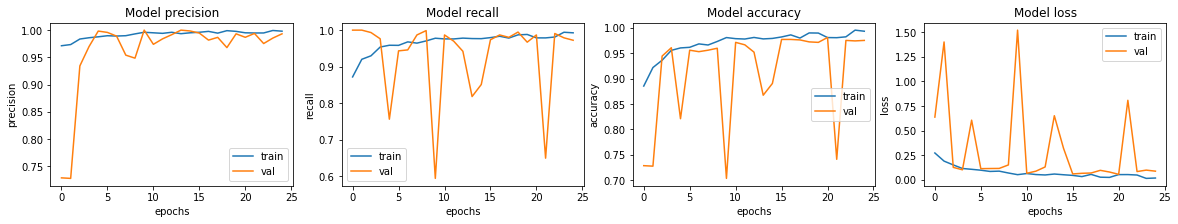

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 4s 99ms/step - loss: 1.2737 - accuracy: 0.8189 - precision: 0.7821 - recall: 0.9846


**dense_block에서 batch normalization layer 제거한 model**

In [23]:
with tf.device('/GPU:0'):
    model = build_model_2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        normal_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=normal_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 36s 140ms/step - loss: 0.3868 - accuracy: 0.8305 - precision: 0.9220 - recall: 0.8438 - val_loss: 0.5907 - val_accuracy: 0.7298 - val_precision: 0.7298 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 35s 136ms/step - loss: 0.2209 - accuracy: 0.9049 - precision: 0.9782 - recall: 0.8925 - val_loss: 2.7965 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 36s 138ms/step - loss: 0.1937 - accuracy: 0.9229 - precision: 0.9787 - recall: 0.9163 - val_loss: 0.1415 - val_accuracy: 0.9471 - val_precision: 0.9512 - val_recall: 0.9776
Epoch 4/25
261/261 [==============================] - 37s 140ms/step - loss: 0.1330 - accuracy: 0.9488 - precision: 0.9840 - recall: 0.9467 - val_loss: 0.3517 - val_accuracy: 0.8288 - val_precision: 1.0000 - val_recall: 0.7652
Epoch 5/25
261/261 [==============================] - 36s 137ms/step - loss: 0.1369 - accura

In [24]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 4s 104ms/step - loss: 3.6494 - accuracy: 0.7163 - precision: 0.6885 - recall: 0.9974


**data augmentation 적용**

In [27]:
with tf.device('/GPU:0'):
    model = build_model_0()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        aug_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=aug_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 37s 140ms/step - loss: 0.3756 - accuracy: 0.8123 - precision: 0.9512 - recall: 0.7886 - val_loss: 0.6304 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 37s 141ms/step - loss: 0.2384 - accuracy: 0.9121 - precision: 0.9689 - recall: 0.9113 - val_loss: 1.6071 - val_accuracy: 0.7298 - val_precision: 0.7298 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 37s 140ms/step - loss: 0.1907 - accuracy: 0.9313 - precision: 0.9803 - recall: 0.9264 - val_loss: 0.1338 - val_accuracy: 0.9500 - val_precision: 0.9447 - val_recall: 0.9895
Epoch 4/25
261/261 [==============================] - 37s 140ms/step - loss: 0.1692 - accuracy: 0.9370 - precision: 0.9814 - recall: 0.9332 - val_loss: 0.1099 - val_accuracy: 0.9635 - val_precision: 0.9775 - val_recall: 0.9723
Epoch 5/25
261/261 [==============================] - 36s 137ms/step - loss: 0.1716 - accura

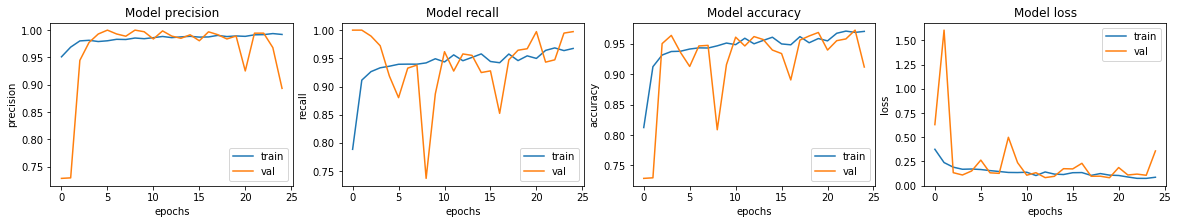

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 4s 99ms/step - loss: 1.8269 - accuracy: 0.6843 - precision: 0.6650 - recall: 0.9974


**EPOCHS = 12**

In [36]:
def build_model_3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [39]:
with tf.device('/GPU:0'):
    model = build_model_3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        normal_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=12,
        validation_data=normal_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/12
261/261 [==============================] - 35s 135ms/step - loss: 0.3720 - accuracy: 0.8149 - precision: 0.9497 - recall: 0.7938 - val_loss: 0.7276 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/12
261/261 [==============================] - 35s 135ms/step - loss: 0.2322 - accuracy: 0.9155 - precision: 0.9726 - recall: 0.9122 - val_loss: 1.2945 - val_accuracy: 0.7298 - val_precision: 0.7298 - val_recall: 1.0000
Epoch 3/12
261/261 [==============================] - 36s 137ms/step - loss: 0.1969 - accuracy: 0.9236 - precision: 0.9739 - recall: 0.9222 - val_loss: 0.0993 - val_accuracy: 0.9567 - val_precision: 0.9650 - val_recall: 0.9764
Epoch 4/12
261/261 [==============================] - 36s 137ms/step - loss: 0.1676 - accuracy: 0.9382 - precision: 0.9815 - recall: 0.9349 - val_loss: 0.2590 - val_accuracy: 0.9077 - val_precision: 1.0000 - val_recall: 0.8734
Epoch 5/12
261/261 [==============================] - 36s 139ms/step - loss: 0.1640 - accura

39/39 [==============================] - 4s 97ms/step - loss: 0.5237 - accuracy: 0.8622 - precision: 0.8378 - recall: 0.9667


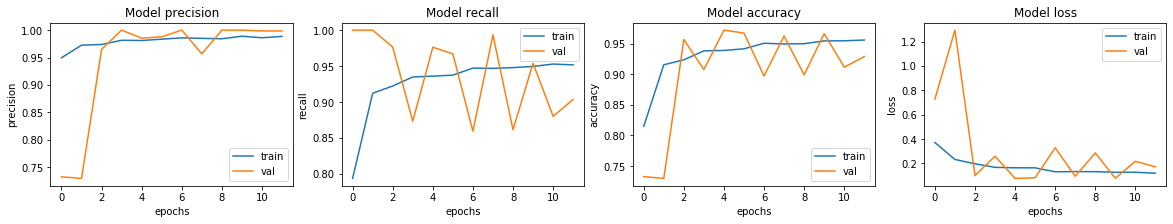

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, acc, prec, rec = model.evaluate(test_ds)

### 회고   

1. dense block에서 batch normalization layer와 dropout layer를 각각 제거해 봤는데, batch norm layer만 있을 때는 기존 둘 다 있을 때와 거의 비슷한 결과가 나왔지만, dropout layer만 있을 땐 상대적으로 훨씬 낮은 정확도를 보였다.   
하지만 세 경우 모두 어느정도 모델이 학습된 후엔 overfitting이 발생하는 것처럼 보였기 때문에 layer를 추가/제거한 것의 영향으로 차이가 나는 것인지는 확실하지 않아보인다.   
   
   
2. augmentation을 적용해서 학습을 시켜봤을 때, 큰 효과가 있다고 느끼긴 어려웠고, overfitting을 해결하는 것이 더 급한 문제라고 생각이 들었다.
   
   
3. 이전의 모델 학습 결과를 시각화 한 그래프를 보고 적절한 EPOCHS 값을 지정해서 모델을 학습시켰을 때 처음으로 test accuracy가 0.85를 넘었다.   
하지만 그래프의 형태가 여전히 진동하는 듯한 형태를 띄기 때문에, 모델 구조를 변경해봐야겠다.